In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')


## fro mFabio
from datetime import datetime, timedelta


from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:38331' processes=28 threads=28>


In [4]:
# # load single ROMS netcdf with xr
# # ds = xr.open_dataset('../data/proc/roms_v11_TotOptions_his_0003_5daymn.nc')
# ds = xr.open_dataset('../data/proc/roms_v11_ctrl_his_0011-13_5daymn_full.nc')
# ds

In [5]:
grd = xr.open_dataset('../data/proc/amery_v11_ctrl_diags_grd.nc')

In [6]:
# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid


grd, grid = ROMSmetricsAndGrid(grd)


making pm/pn metrics
making dx/dy


In [22]:
# load single ROMS netcdf with xr
# ds = xr.open_dataset('/g/data/jk72/deg581/apom/ana/data/proc/roms_v11_ctrl_dia_0018-19_5daymn_full.nc')
data_set_path = '/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_his_0018.nc'
ds = xr.open_dataset(data_set_path)
ds


<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 365)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
    x_u            (eta_u, xi_u) float64 ...
    y_u            (eta_u, xi_u) float64 ...
    x_v            (eta_v, xi_v) float64 ...
    y_v            (eta_v, xi_v) float64 ...
    x_psi          (eta_psi, xi_psi) float64 ...
    y_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2023-12-29 ... 2024-12-27
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/89)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    rho            (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    sustr          (ocean_time, eta_u, xi_u) float32 ...
    svstr          (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/35)
    file:              roms_his_0018.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Thursday - July 25, 2024 -  2:...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL, ANA_SRFLUX...

In [23]:
%%time
ubar=ds['ubar']
vbar=ds['vbar']


CPU times: user 160 µs, sys: 34 µs, total: 194 µs
Wall time: 215 µs


In [24]:
%%time
us=ds['u'].isel(s_rho=-1)
vs=ds['v'].isel(s_rho=-1)
u15=ds['u'].isel(s_rho=15)
v15=ds['v'].isel(s_rho=15)
ubot=ds['u'].isel(s_rho=0)
vbot=ds['v'].isel(s_rho=0)

CPU times: user 6.61 ms, sys: 10 ms, total: 16.6 ms
Wall time: 15.3 ms


In [25]:
%%time
us.load()
vs.load()
ubar.load()
vbar.load()
u15.load()
v15.load()
ubot.load()
vbot.load()

CPU times: user 23.8 s, sys: 14.3 s, total: 38.2 s
Wall time: 1min 28s


<xarray.DataArray 'v' (ocean_time: 365, eta_v: 749, xi_v: 900)>
array([[[            nan,             nan,             nan, ...,
          6.30551390e-03,  7.96012394e-03,  6.27784245e-03],
        [            nan,             nan,             nan, ...,
         -1.49525260e-03,  4.90513537e-03,  4.59526572e-03],
        [            nan,             nan,             nan, ...,
         -8.29420402e-04,  1.50762256e-02,  2.10516970e-03],
        ...,
        [            nan,             nan,             nan, ...,
          9.53202024e-02,  5.79346064e-03,  6.06228262e-02],
        [            nan,             nan,             nan, ...,
          1.02989905e-01, -5.60410246e-02,  3.88030708e-02],
        [            nan,             nan,             nan, ...,
          8.47057998e-02,  7.23651275e-02,  5.56122139e-02]],

       [[            nan,             nan,             nan, ...,
          6.46736613e-03,  8.48861691e-03,  6.34464994e-03],
        [            nan,             nan,             nan, ...,
         -1.39021629e-03,  3.97879444e-03,  4.20044921e-03],
        [            nan,             nan,             nan, ...,
         -3.13099736e-05,  1.54078500e-02,  2.01593875e-03],
...
          8.83656368e-02,  6.67872801e-02,  1.02450602e-01],
        [            nan,             nan,             nan, ...,
          9.18576568e-02,  3.56375463e-02,  7.73205310e-02],
        [            nan,             nan,             nan, ...,
          9.32065547e-02,  8.60563219e-02,  8.17298368e-02]],

       [[            nan,             nan,             nan, ...,
          5.79761155e-03,  1.06545696e-02,  6.35132007e-03],
        [            nan,             nan,             nan, ...,
         -7.25321879e-04,  9.52655822e-03,  2.04775226e-03],
        [            nan,             nan,             nan, ...,
         -1.98464771e-03,  2.20839423e-03, -1.90409261e-03],
        ...,
        [            nan,             nan,             nan, ...,
          1.00656487e-01,  7.18243495e-02,  6.98931068e-02],
        [            nan,             nan,             nan, ...,
          1.06349923e-01,  7.12513998e-02,  6.01706095e-02],
        [            nan,             nan,             nan, ...,
          8.20544958e-02,  7.29697123e-02,  6.66073635e-02]]],
      dtype=float32)
Coordinates:
    s_rho       float64 -0.9839
    x_v         (eta_v, xi_v) float64 1.501e+06 1.503e+06 ... 3.299e+06
    y_v         (eta_v, xi_v) float64 2e+03 2e+03 2e+03 ... 1.498e+06 1.498e+06
  * ocean_time  (ocean_time) datetime64[ns] 2023-12-29 2023-12-30 ... 2024-12-27
Dimensions without coordinates: eta_v, xi_v
Attributes:
    standard_name:  sea_water_y_velocity
    long_name:      v-momentum component
    units:          meter second-1
    time:           ocean_time
    cell_methods:   ocean_time: point
    grid:           grid
    location:       edge2
    field:          v-velocity

In [26]:
%%time
print('mapping u/v to u/v rho')
us_rho = grid.interp(us,'X')
vs_rho = grid.interp(vs,'Y')

u15_rho = grid.interp(u15,'X')
v15_rho = grid.interp(v15,'Y')

ubot_rho = grid.interp(ubot,'X')
vbot_rho = grid.interp(vbot,'Y')

ubar_rho = grid.interp(ubar,'X')
vbar_rho = grid.interp(vbar,'Y')

us_rho['ocean_time'] = ds.ocean_time
vs_rho['ocean_time'] = ds.ocean_time
ubar_rho['ocean_time'] = ds.ocean_time
vbar_rho['ocean_time'] = ds.ocean_time
u15_rho['ocean_time'] = ds.ocean_time
v15_rho['ocean_time'] = ds.ocean_time
ubot_rho['ocean_time'] = ds.ocean_time
vbot_rho['ocean_time'] = ds.ocean_time

mapping u/v to u/v rho
CPU times: user 5.36 s, sys: 4.25 s, total: 9.61 s
Wall time: 8.05 s


In [27]:
# finished pre-processing. Now convert to numpy arrays to get away from any xarray issues.

In [28]:
us_rho_subset   = us_rho.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time')
vs_rho_subset   = vs_rho.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time')
ubar_rho_subset = ubar_rho.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time')
vbar_rho_subset = vbar_rho.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time')


In [29]:
us_rho_subset   = us_rho_subset.values   
vs_rho_subset   = vs_rho_subset.values   
ubar_rho_subset = ubar_rho_subset.values 
vbar_rho_subset = vbar_rho_subset.values 

In [30]:
%%time
np.sqrt(us_rho_subset*us_rho_subset + vs_rho_subset*vs_rho_subset)

CPU times: user 5.06 ms, sys: 0 ns, total: 5.06 ms
Wall time: 2.43 ms


array([[       nan,        nan,        nan, ..., 0.08912951, 0.07192986,
               nan],
       [       nan,        nan,        nan, ..., 0.01776007, 0.02015652,
               nan],
       [       nan,        nan,        nan, ..., 0.00572973, 0.00890075,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.22189781, 0.17851184,
               nan],
       [       nan,        nan,        nan, ..., 0.21009582, 0.16851714,
               nan],
       [       nan,        nan,        nan, ..., 0.15382119, 0.13871777,
               nan]], dtype=float32)

now making means
calculating vel mag
CPU times: user 205 ms, sys: 54.4 ms, total: 259 ms
Wall time: 261 ms


(500000.0, 1000000.0)

<Figure size 640x480 with 0 Axes>

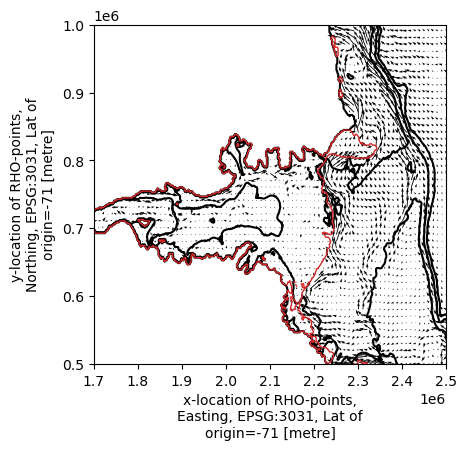

In [31]:
%%time

print('now making means')
uvel=us_rho_subset
vvel=vs_rho_subset
vel_mag = np.sqrt(uvel**2+vvel**2)
print('calculating vel mag')
str_kwargs = {"color":vel_mag,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}


gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15])
ax = None

ax=fig.add_subplot(gs[0,0])

# st = ax.streamplot(grd.x_rho.values, grd.y_rho.values, uvel, vvel,**str_kwargs)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel[0::5,0::5], vvel[0::5,0::5],scale=5)
co2 = (grd.h*grd.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,500,1000,1500),colors='k')
co3 = ax.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)

now making means
calculating vel mag
CPU times: user 481 ms, sys: 72.9 ms, total: 554 ms
Wall time: 509 ms


(500000.0, 1000000.0)

<Figure size 640x480 with 0 Axes>

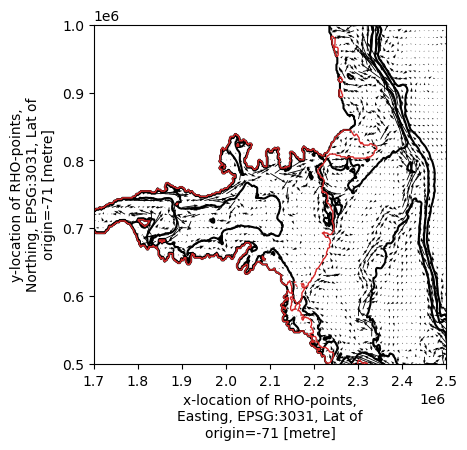

In [32]:
%%time

print('now making means')
uvel=ubar_rho_subset
vvel=vbar_rho_subset
vel_mag = np.sqrt(uvel**2+vvel**2)
print('calculating vel mag')
str_kwargs = {"color":vel_mag,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}


gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15])
ax = None

ax=fig.add_subplot(gs[0,0])

# st = ax.streamplot(grd.x_rho.values, grd.y_rho.values, uvel, vvel,**str_kwargs)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel[0::5,0::5], vvel[0::5,0::5],scale=2.5)
co2 = (grd.h*grd.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,500,1000,1500),colors='k')
co3 = ax.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)

In [18]:
 grd.y_rho.values[0::5,0::5]

array([[1.00000031e+03, 1.00000031e+03, 1.00000031e+03, ...,
        1.00000067e+03, 1.00000067e+03, 1.00000068e+03],
       [1.10000003e+04, 1.10000003e+04, 1.10000003e+04, ...,
        1.10000007e+04, 1.10000007e+04, 1.10000007e+04],
       [2.10000003e+04, 2.10000003e+04, 2.10000003e+04, ...,
        2.10000007e+04, 2.10000007e+04, 2.10000007e+04],
       ...,
       [1.47100000e+06, 1.47100000e+06, 1.47100000e+06, ...,
        1.47100000e+06, 1.47100000e+06, 1.47100000e+06],
       [1.48100000e+06, 1.48100000e+06, 1.48100000e+06, ...,
        1.48100000e+06, 1.48100000e+06, 1.48100000e+06],
       [1.49100000e+06, 1.49100000e+06, 1.49100000e+06, ...,
        1.49100000e+06, 1.49100000e+06, 1.49100000e+06]])

now making means
calculating vel mag
CPU times: user 1min 25s, sys: 1.87 s, total: 1min 27s
Wall time: 1min 25s


(500000.0, 1000000.0)

<Figure size 640x480 with 0 Axes>

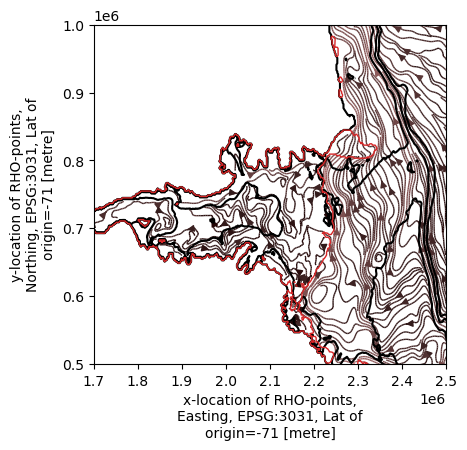

In [19]:
%%time

print('now making means')
uvel=us_rho_subset
vvel=vs_rho_subset
vel_mag = np.sqrt(uvel**2+vvel**2)
print('calculating vel mag')
str_kwargs = {"color":vel_mag,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}
# ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)


gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15])
ax = None

ax=fig.add_subplot(gs[0,0])

st = ax.streamplot(grd.x_rho.values, grd.y_rho.values, uvel, vvel,**str_kwargs)
co2 = (grd.h*grd.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,500,1000,1500),colors='k')
co3 = ax.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)

now making means
calculating vel mag
CPU times: user 2min 54s, sys: 2.97 s, total: 2min 57s
Wall time: 2min 54s


(500000.0, 1000000.0)

<Figure size 640x480 with 0 Axes>

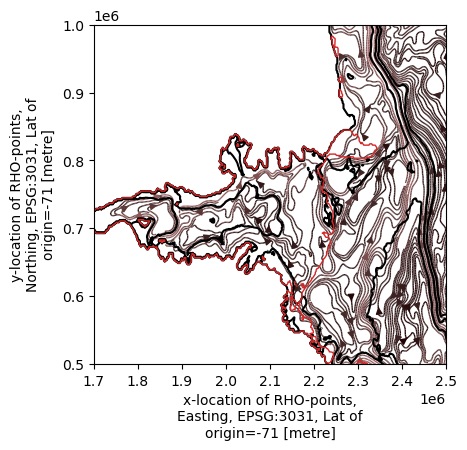

In [20]:
%%time

print('now making means')
uvel=ubar_rho_subset
vvel=vbar_rho_subset
vel_mag = np.sqrt(uvel**2+vvel**2)
print('calculating vel mag')
str_kwargs = {"color":vel_mag,
              "linewidth":1,
              "arrowsize":1,
              "density":20,
              "cmap":"pink"}
# ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)


gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15])
ax = None

ax=fig.add_subplot(gs[0,0])

st = ax.streamplot(grd.x_rho.values, grd.y_rho.values, uvel, vvel,**str_kwargs)
co2 = (grd.h*grd.mask_rho).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,500,1000,1500),colors='k')
co3 = ax.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)

(2212500.0, 450000.0)
(2267461.3292856165, 461178.57544792147)


Text(0, 0.5, 'potential temperature ($^\\circ$C)')

<Figure size 640x480 with 0 Axes>

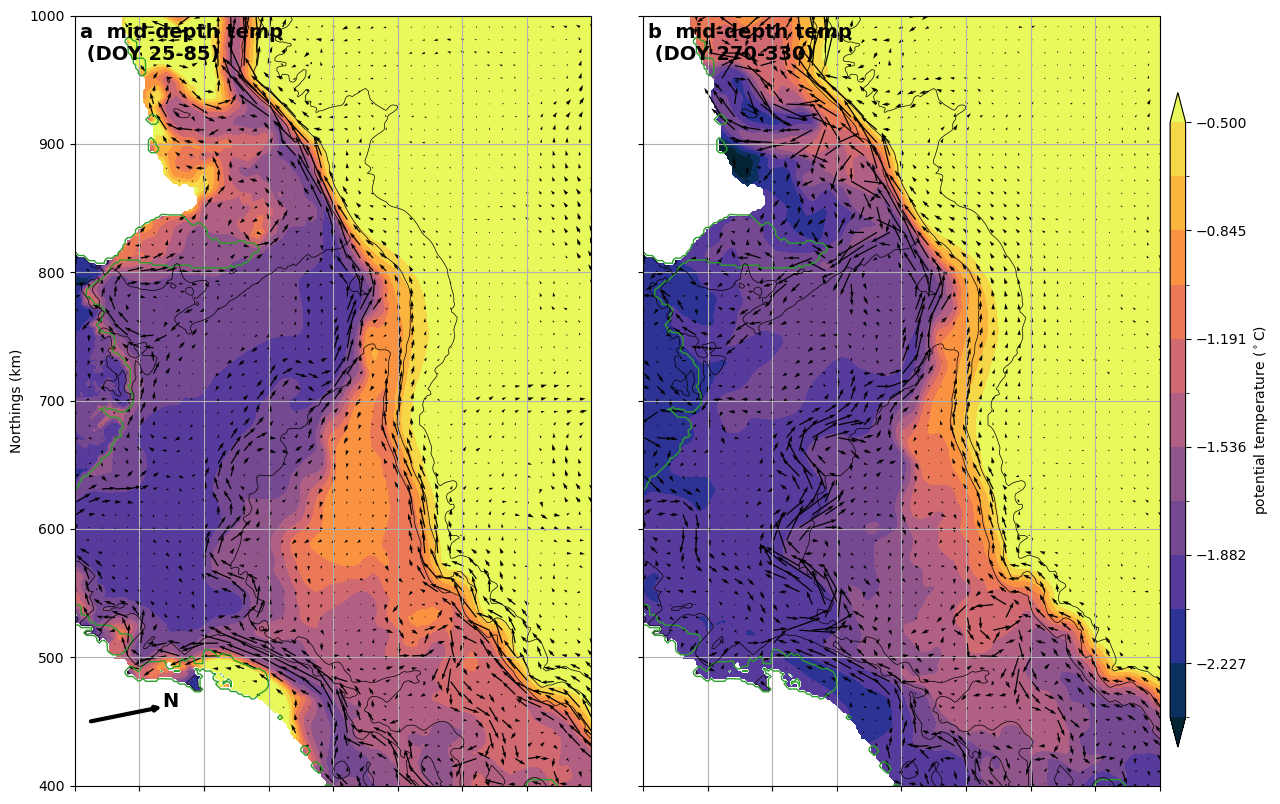

In [40]:
us_rho_feb   = u15_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
vs_rho_feb   = v15_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
us_rho_oct   = u15_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   
vs_rho_oct   = v15_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   


uvel1=us_rho_feb
vvel1=vs_rho_feb
uvel2=us_rho_oct
vvel2=vs_rho_oct


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,10])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
# temp400_FM.plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
im = ds.temp.isel(s_rho=15).isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=2.5)

co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  mid-depth temp\n (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(2.2125e6,0.45e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
im = ds.temp.isel(s_rho=15).isel(ocean_time=slice(270,330)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=2.5)

# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  mid-depth temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')









(2212500.0, 450000.0)
(2267461.3292856165, 461178.57544792147)


Text(0, 0.5, 'potential temperature ($^\\circ$C)')

<Figure size 640x480 with 0 Axes>

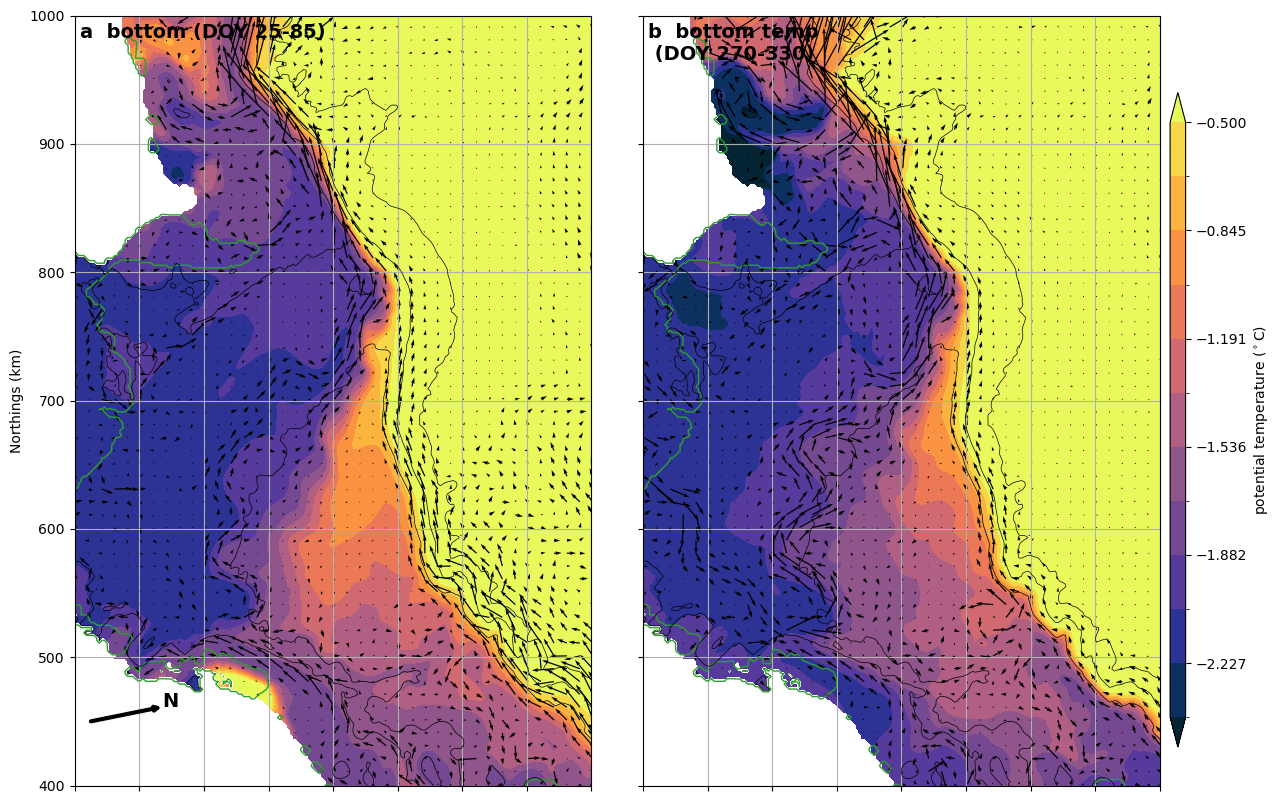

In [36]:
us_rho_feb   = ubot_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
vs_rho_feb   = vbot_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
us_rho_oct   = ubot_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   
vs_rho_oct   = vbot_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   


uvel1=us_rho_feb
vvel1=vs_rho_feb
uvel2=us_rho_oct
vvel2=vs_rho_oct


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,10])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
# temp400_FM.plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
im = ds.temp.isel(s_rho=0).isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=2.5)

co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  bottom (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(2.2125e6,0.45e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
im = ds.temp.isel(s_rho=0).isel(ocean_time=slice(270,330)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=2.5)

# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  bottom temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')









(2212500.0, 450000.0)
(2267461.3292856165, 461178.57544792147)


Text(0, 0.5, 'potential temperature ($^\\circ$C)')

<Figure size 640x480 with 0 Axes>

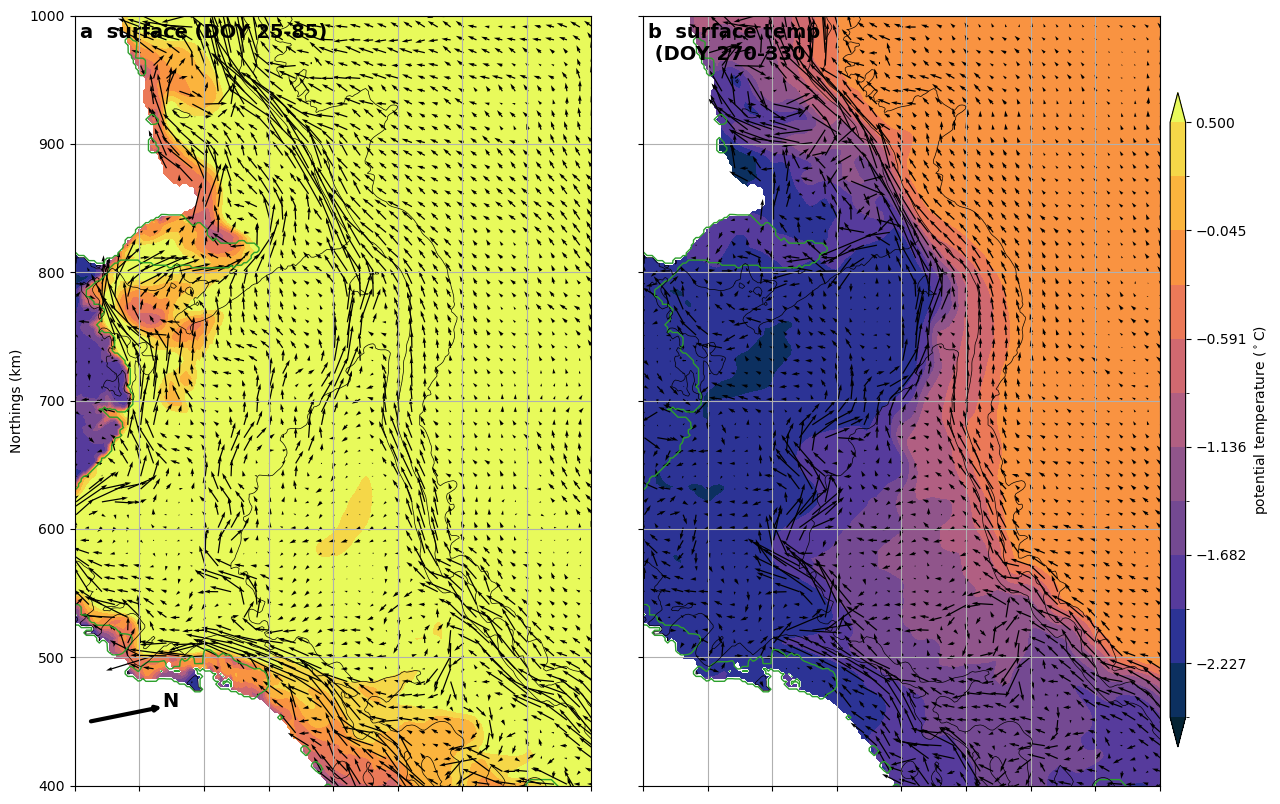

In [41]:
us_rho_feb   = us_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
vs_rho_feb   = vs_rho.sel(ocean_time=slice('2024-01-25','2024-03-26')).mean(dim='ocean_time').values   
us_rho_oct   = us_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   
vs_rho_oct   = vs_rho.sel(ocean_time=slice('2024-09-27','2024-11-26')).mean(dim='ocean_time').values   


uvel1=us_rho_feb
vvel1=vs_rho_feb
uvel2=us_rho_oct
vvel2=vs_rho_oct


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,10])
ax = None



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(5,18)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,0])
# temp400_FM.plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.4,vmax=-.5,levels=12)
im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=2.5)

co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
# ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'a  surface (DOY 25-85)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_yticklabels([])
ax.set_ylabel('Northings (km)')
ax.set_xticklabels([])
ax.set_title('')


# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

arr_start_ps=(2.2125e6,0.45e6)
arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
print(arr_start_ps)
arr_end = ll_to_ps.transform(arr_start[0]+0.5,arr_start[1])
print(arr_end)
ax.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)



# uvel=ds.u_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vvel=ds.v_rho.isel(s_rho=-2).isel(ocean_time=slice(55,67)).mean(dim='ocean_time')
# vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
# str_kwargs = {"color":vel_mag.values,
#               "linewidth":1,
#               "arrowsize":1,
#               "density":8,
#               "cmap":"pink"}
ax=fig.add_subplot(gs[0,1])
im = ds.temp.isel(s_rho=-2).isel(ocean_time=slice(270,330)).mean(dim='ocean_time').plot.contourf(ax=ax,x='x_rho',y='y_rho',cmap='cmo.thermal',add_colorbar=False,vmin=-2.5,vmax=.5,levels=12)
ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel2[0::5,0::5], vvel2[0::5,0::5],scale=2.5)

# st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, uvel.values, vvel.values,**str_kwargs)
# po = plt.plot(ds.x_rho.isel(eta_rho=min_eta),ds.y_rho.isel(eta_rho=min_eta),color='C1',linewidth=0.5)
co1 = ax.contour(ds.x_rho,ds.y_rho,ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co2 = ax.contour(ds.x_rho,ds.y_rho,ds.h*ds.mask_rho,levels=(500,1000,2000),colors='k',linestyles='-',linewidths=0.5)
ax.set_xlim((2.2e6,2.6e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('')
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  surface temp\n (DOY 270-330)', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title('')


cax = inset_axes(ax,
                width="1.5%",  # width = 10% of parent_bbox width
                height="85%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.02,.05, 2, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='vertical') 
cax.set_ylabel(r'potential temperature ($^\circ$C)')









In [21]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# load single ROMS netcdf with xr
# ds = xr.open_dataset('/g/data/jk72/deg581/apom/ana/data/proc/roms_v11_ctrl_dia_0018-19_5daymn_full.nc')
data_set_path = '/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_his_0019.nc'
ds = xr.open_dataset(data_set_path)
ds


In [ ]:
# %%time
# ubar=ds['ubar']
# vbar=ds['vbar']


In [ ]:
%%time
us=ds['u'].isel(s_rho=-1)
vs=ds['v'].isel(s_rho=-1)


In [ ]:
%%time
us.load()
vs.load()

In [ ]:
%%time
print('mapping u/v to u/v rho')
us_rho = grid.interp(us,'X')
vs_rho = grid.interp(vs,'Y')

us_rho['ocean_time'] = ds.ocean_time
vs_rho['ocean_time'] = ds.ocean_time


In [ ]:
us_rho = us_rho.sel(ocean_time=slice('2025-02-01','2025-03-01')).mean(dim='ocean_time')
vs_rho = vs_rho.sel(ocean_time=slice('2025-02-01','2025-03-01')).mean(dim='ocean_time')

In [ ]:
print('saving us_rho ',us_rho.nbytes/1e9,'G')
us_rho.to_netcdf('../data/proc/amery_v11_ctrl_diags_us_rho.nc')
us_rho
print('saving us_rho ',vs_rho.nbytes/1e9,'G')
vs_rho.to_netcdf('../data/proc/amery_v11_ctrl_diags_vs_rho.nc')
vs_rho

In [ ]:
STOP

In [ ]:
%%time
us_rho.load()
vs_rho.load()

In [ ]:
us_rho.plot()

In [ ]:
vs_rho.plot()

In [ ]:
(us_rho+vs_rho).plot()

In [ ]:
STOP

In [ ]:
(us_rho.mean(dim='ocean_time')**2+vs_rho.mean(dim='ocean_time')**2).plot()

In [ ]:
%%time
print('now making means')
uvel=us_rho.mean(dim='ocean_time')
vvel=vs_rho.mean(dim='ocean_time')
vel_mag = np.sqrt(uvel**2+vvel**2).squeeze()**0.5
print('calculating vel mag')
str_kwargs = {"color":vel_mag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":15,
              "cmap":"pink"}
# ds.temp.isel(s_rho=-1).isel(ocean_time=slice(5,18)).mean(dim='ocean_time').plot.contourf(x='x_rho',y='y_rho',cmap='cmo.thermal',vmin=-2.4,vmax=-1.5,levels=12)
st = plt.streamplot(grd.x_rho.values, grd.y_rho.values, uvel.values, vvel.values,**str_kwargs)

In [ ]:
STOP

In [ ]:

gs = gridspec.GridSpec(nrows=4,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,15])
ax = None

ax=fig.add_subplot(gs[0,0])
(salt_hadv_int+salt_vadv_int+salt_hdiff_int+salt_vdiff_int).sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',vmin=-2e-5,vmax=2e-5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('Northings')
ax.text(0.01, 0.99, 'a  mean salinity tendency', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


ax=fig.add_subplot(gs[0,1])
salt_vdiff_int.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',vmin=-2e-5,vmax=2e-5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  mean surface vertical diffusion', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
salt_hadv_int.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',vmin=-2e-5,vmax=2e-5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('Northings')
ax.text(0.01, 0.99, 'b  mean salinity horizontal advection', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,1])
salt_hdiff_int.sel(ocean_time=slice('2024-02-01','2024-03-01')).mean(dim='ocean_time').plot(x='x_rho',y='y_rho',vmin=-2e-5,vmax=2e-5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(1.7e6,2.5e6)
ax.set_ylim(.5e6,1e6)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.text(0.01, 0.99, 'b  mean salinity horizontal diffusion', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')


In [ ]:
STOP

In [ ]:
# load single ROMS netcdf with xr
# ds = xr.open_dataset('/g/data/jk72/deg581/apom/ana/data/proc/roms_v11_ctrl_dia_0018-19_5daymn_full.nc')
data_set_path = '/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_dia_0018.nc'
ds = xr.open_dataset(data_set_path)

grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v12_grd.nc')

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r

grd = grd.assign_coords({"x_rho": grd.x_rho})
grd = grd.assign_coords({"y_rho": grd.y_rho})
grd = grd.assign_coords({"lon_rho": grd.lon_rho})
grd = grd.assign_coords({"lat_rho": grd.lat_rho})

# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_zice_nan'] = (grd.mask_rho.where(grd.zice<0)==1).where(grd.mask_rho.where(grd.zice<0)==1) # make a mask where non-ice is nan

def loadDataSet(path):
    ds = xr.open_dataset(path)
    return ds

In [ ]:
# ds = loadDataSet(data_set_path)
# ds_salt_rate = ds['salt_rate']
# ds_salt_rate.load()
# print('loaded ',ds_salt_rate.nbytes/1e9,'G')

In [ ]:
%%time

ds = loadDataSet(data_set_path)
salt_hadv = ds['salt_hadv']
salt_hadv.load()
print('loaded ',salt_hadv.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_vadv = ds['salt_vadv']
salt_vadv.load()
print('loaded ',salt_vadv.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_hdiff = ds['salt_hdiff']
salt_hdiff.load()
print('loaded ',salt_hdiff.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_vdiff = ds['salt_vdiff']
salt_vdiff.load()
print('loaded ',salt_vdiff.nbytes/1e9,'G')

# ds = loadDataSet(data_set_path)
# ds_salt_rate = ds['salt_rate']
# ds_salt_rate.load()
# print('loaded ',ds_salt_rate.nbytes/1e9,'G')

In [ ]:
%%time
ds = loadDataSet(data_set_path)
zeta = ds['zeta']
zeta.load()
print('loaded ',zeta.nbytes/1e9,'G')

In [ ]:
%%time
hwater = grd.h- abs(grd.zice) # replace ds.h for hwater below
Zo_rho = (grd.hc * grd.s_rho + grd.Cs_r * hwater) / (grd.hc + hwater)
z_rho = zeta + (zeta + hwater) * Zo_rho 

Zo_w = (grd.hc * grd.s_w + grd.Cs_w * hwater) / (grd.hc + hwater)
z_w = zeta + (zeta + hwater) * Zo_w 


Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)

In [ ]:
1+1

In [ ]:
del zeta, Z_w, hwater, z_w
ds.close()

In [ ]:
%%time 

salt_hadv_dz = salt_hadv*dz
print('loaded salt_hadv_dz ',salt_hadv_dz.nbytes/1e9,'G')
del salt_hadv

salt_vadv_dz = salt_vadv*dz
print('loaded salt_vadv_dz ',salt_hadv_dz.nbytes/1e9,'G')
del salt_vadv

salt_hdiff_dz = salt_hdiff*dz
print('loaded salt_hdiff_dz ',salt_hadv_dz.nbytes/1e9,'G')
del salt_hdiff

salt_vdiff_dz = salt_vdiff*dz
print('loaded salt_vdiff_dz ',salt_hadv_dz.nbytes/1e9,'G')

del salt_vdiff,dz

In [ ]:
# %%time

# # calculate dz

# ds = loadDataSet(data_set_path)

# print("Vtransform=2")
# #  New formulation (Vtransform(ng) = 2):
# #
# #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
# #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
# hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
# Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
# z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 

# Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
# z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 

# ds.close()


# Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
# print(z_w.shape, Z_w.shape)
# dz = np.diff(Z_w,axis=1)

# # dz.load()

In [ ]:
# %%time

# ds = loadDataSet(data_set_path)
# salt_hadv = ds['salt_hadv']
# salt_hadv.load()
# print('loaded ',salt_hadv.nbytes/1e9,'G')

# ds = loadDataSet(data_set_path)
# salt_vadv = ds['salt_vadv']
# salt_vadv.load()
# print('loaded ',salt_vadv.nbytes/1e9,'G')

# ds = loadDataSet(data_set_path)
# salt_hdiff = ds['salt_hdiff']
# salt_hdiff.load()
# print('loaded ',salt_hdiff.nbytes/1e9,'G')

# ds = loadDataSet(data_set_path)
# salt_vdiff = ds['salt_vdiff']
# salt_vdiff.load()
# print('loaded ',salt_vdiff.nbytes/1e9,'G')

# # ds = loadDataSet(data_set_path)
# # salt_rate = ds['salt_rate']
# # salt_rate.load()
# # print('loaded ',salt_rate.nbytes/1e9,'G')

In [ ]:
# %%time 

# salt_hadv_dz = salt_hadv*dz

# salt_vadv_dz = salt_vadv*dz

# salt_hdiff_dz = salt_hdiff*dz

# salt_vdiff_dz = salt_vdiff*dz


In [ ]:
# ds = ds.drop_vars(['temp_xadv','temp_yadv','temp_xdiff','temp_ydiff','salt_xadv','salt_yadv','salt_xdiff','salt_ydiff','temp_sdiff','salt_sdiff'])
# ds = ds.drop_vars(['temp_rate','temp_hadv','temp_vadv','temp_hdiff','temp_vdiff','zeta'])
# print(ds.nbytes/1e9,'G')
# ds

In [ ]:
# # chop in time, selecting a smaller segment
# ds = ds.sel(ocean_time=slice('2023-01-01','2025-01-01'))

In [ ]:
# make masks

# now make a ROI mask(s)
# plt.figure(figsize=(6,4))
# grd.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


grd['mask_zice_roi'] = grd.mask_zice*mask_roi
# grd.mask_zice_roi.plot()
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"

In [ ]:
from matplotlib.patches import Rectangle

#%matplotlib widget

plt.figure(figsize=(10,10)),
# grd.my_doy.mean(dim='dayofyear').plot(x='x_rho',y='y_rho',cmap='RdBu',vmin=0,vmax=10)
grd.h.plot.contour(x='x_rho',y='y_rho',levels=(0,100,200,300,400,500),colors='k')
(-1*grd.zice*grd.mask_rho).plot.contour(x='x_rho',y='y_rho',levels=(0,1),colors='r')

pnt_bl=(2.21e6,.77e6)
pnt_tr=(2.28e6,.85e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.28e6,.77e6)
pnt_tr=(2.34e6,.85e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.24e6,.85e6)
pnt_tr=(2.34e6,.88e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.24e6,.88e6)
pnt_tr=(2.34e6,.91e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))



pnt_bl=(2.18e6,.77e6)
pnt_tr=(2.21e6,.81e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))




%matplotlib inline

In [ ]:
# make masks for salt box

pnt_bl=(2.21e6,.77e6)
pnt_tr=(2.28e6,.85e6)


# make a mask for where we want to include in the average
mask_mac = np.zeros_like(grd.lon_rho)
mask_mac[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_mac)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.28e6,.77e6)
pnt_tr=(2.34e6,.85e6)


# make a mask for where we want to include in the average
mask_cdit = np.zeros_like(grd.lon_rho)
mask_cdit[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdit)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.24e6,.85e6)
pnt_tr=(2.34e6,.88e6)


# make a mask for where we want to include in the average
mask_cdpe = np.zeros_like(grd.lon_rho)
mask_cdpe[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdpe)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()


pnt_bl=(2.24e6,.88e6)
pnt_tr=(2.34e6,.91e6)


# make a mask for where we want to include in the average
mask_cdpw = np.zeros_like(grd.lon_rho)
mask_cdpw[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdpw)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.18e6,.77e6)
pnt_tr=(2.21e6,.81e6)


# make a mask for where we want to include in the average
mask_aiso = np.zeros_like(grd.lon_rho)
mask_aiso[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_aiso)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



In [ ]:
# salt_rate.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
(salt_hadv_dz+salt_vadv_dz+salt_hdiff_dz+salt_vdiff_dz).isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
(salt_hadv_dz).isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vadv_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_hdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
salt_hdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
salt_vdiff_dz.sum(dim='s_rho').mean(dim='ocean_time').plot()

In [ ]:
ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_his_0018.nc')
ssflux = ds_his["ssflux"] 
ds_his.close()

In [ ]:
ssflux.mean(dim='ocean_time').plot()

In [ ]:
STOP

In [ ]:
ds.salt

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)


plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'salinity')

ax=fig.add_subplot(gs[1,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)


plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'pot temp')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),'C1')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim((-200,200))
ax2 = ax.twinx()
ax2.plot(ds.ocean_time,ds.ssflux.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),'C0')
ax2.autoscale(enable=True, axis='x', tight=True)
# ax2.set_ylim((-2,2))

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),'C1')
plt.plot(ds.ocean_time,ds.ssflux.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),'C0')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None


where_x=390
where_e=440

ax=fig.add_subplot(gs[0,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.salt.isel(xi_rho=where_x,eta_rho=where_e).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)


plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.salt.isel(xi_rho=where_x,eta_rho=where_e).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'salinity')

ax=fig.add_subplot(gs[1,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)


plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,
            [-1.95],colors='C1',linestyles='-')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'pot temp')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.isel(xi_rho=where_x,eta_rho=where_e),'C1')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim((-400,200))
ax2 = ax.twinx()
ax2.plot(ds.ocean_time,-ds.ssflux.isel(xi_rho=where_x,eta_rho=where_e),'C0')
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.set_ylim((-4*1e-5,2*1e-5))

In [ ]:
# now make those poster plots again

In [ ]:
# now look at heat coming onto shelf
target_depth = -400

temp400 = grid.transform(ds.temp, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()

temp400_clima = temp400.groupby('ocean_time.dayofyear').mean()

In [ ]:
from scipy.ndimage import gaussian_filter1d


temp400.isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot(vmin=-2,vmax=-.5)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((325,475,225,450))
plt.plot(450,335,'x',color='C1')
plt.plot(408,262,'x',color='C2')
plt.show()

plt.plot(ds.ocean_time,temp400.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=.5,label='400m temp - outer shelf')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=2.5,label='400m temp - outer shelf (5-day filter)')
plt.plot(ds.ocean_time,temp400.isel(xi_rho=408,eta_rho=262),color='C2',linewidth=.5,label='400m temp - coast')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=408,eta_rho=262), 5),color='C2',linewidth=2.5,label='400m temp - coast (5-day filter)')
plt.show()



In [ ]:
image_save_dpi = 1000

# # plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=1.5)#,label='400m temp - outer shelf')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=5,label='400m temp @ outer shelf')
ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=408,eta_rho=262),color='lightcoral',linewidth=1.5)#,label='400m temp - coast')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=408,eta_rho=262), 5),color='lightcoral',linewidth=5,label='400m temp @ coast')



# ax.annotate("400m temp @ outer shelf",
#             xy=(250,-1), xycoords='data',
#             xytext=(250,-1), textcoords='data',
#             size=40, va="center", ha="center",
#             bbox=dict(boxstyle="round4", fc="w", alpha=0.75))

# # plt.rcParams.update({'font.size': 16})
# # plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'Temperature ($\theta$ $^\circ$C)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='upper right')
ax.set_title('')

In [ ]:
# now melt rate variability
ds['m'] = ds.m.where(ds.m<1e35,np.NaN)
ds['my'] = ds.m*(60*60*24*365)
# ds.my.mean(dim='ocean_time').where(ds.zice<-500).plot(vmin=-10,vmax=10)
# time evolution of melt rate

ds['my_doy'] = ds.my.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C0',linewidth=5,label='mean melt')
(ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5)#,label='mean melt (zice>500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=5,label='mean melt (zice>500m)')

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='lower left')
ax.set_title('')


In [ ]:
(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='dayofyear')


In [ ]:
# isw plume strength
import seawater as sw

sigma_0_surf = sw.pden(ds.salt.isel(s_rho=-1).values,sw.temp(ds.salt.isel(s_rho=-1).values,ds.temp.isel(s_rho=-1).values,ds.z_rho0.isel(s_rho=-1).values),ds.z_rho0.isel(s_rho=-1).values,0)-1000
ds['sigma_0_surf']=(('ocean_time','eta_rho','xi_rho'),sigma_0_surf)


mask = np.zeros_like(ds.lon_rho)
mask[380:386,318:323]=1


ds['sigma_0_surf_clima'] = ds.sigma_0_surf.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='orangered',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='orangered',linewidth=5,label='AIS mean melt')
# (ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=.5)#,label='mean melt (zice>500m)')
# plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=2,label='mean melt (zice>500m)')


ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin')#, color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(ds.dayofyear,ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),color='skyblue',linewidth=1.5)
ax2.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),2),color='skyblue',linewidth=5,label='$\sigma_0$ @ outflow')
ax2.set_ylabel('surface $\sigma_0$ anomay (kg/m$^3$)')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False,loc='lower left')

# ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
frc = xr.open_dataset('../../frc/amery_v2km_tamura+era_shflux.nc')



In [ ]:


# make heat flux plot
(frc.shflux*ds.mask_rho*~ds.mask_zice).mean(dim='shf_time').plot(levels=12)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((300,450,350,600))
plt.plot(390,440,'x',color='C1')
plt.plot(362,391,'x',color='C2')

plt.show()

plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='C1',linewidth=.5,label='shflux - CD')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='C1',linewidth=2.5,label='shflux - CD (5-day filter)')
plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=.5,label='shflux - Ma')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=2.5,label='shflux - Ma (5-day filter)')


In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=1.5)#,label='shflux - Ma')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=5,label='Mackenzie polynya')
ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)#,label='shflux - CD')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='steelblue',linewidth=5,label='Cape Darnley')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'surface heat flux (W/m$^2$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
# make bottom density 
sigma_0_bot = sw.pden(ds.salt.isel(s_rho=0).values,sw.temp(ds.salt.isel(s_rho=0).values,ds.temp.isel(s_rho=0).values,ds.z_rho0.isel(s_rho=0).values),ds.z_rho0.isel(s_rho=0).values,0)-1000
ds['sigma_0_bot']=(('ocean_time','eta_rho','xi_rho'),sigma_0_bot)


ds['sigma_0_bot_clima'] = ds.sigma_0_bot.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])



# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)
ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440), 2),color='steelblue',linewidth=5,label='bottom $\sigma_0$ - Cape Darnley')
# ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462),color='C4',linewidth=.5)
# ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462), 2),color='C4',linewidth=2.5,label='bottom $\sigma_0$ - Burton basin')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('bottom $\sigma_0$ anomaly (kg/m$^3$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='upper left')
ax.set_title('')





In [ ]:
STOP

In [ ]:
# now look at heat coming onto shelf
target_depth = -400

temp400 = grid.transform(ds.temp, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()

temp400_clima = temp400.groupby('ocean_time.dayofyear').mean()

In [ ]:
from scipy.ndimage import gaussian_filter1d


temp400.isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot(vmin=-2,vmax=-.5)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((325,475,225,450))
plt.plot(450,335,'x',color='C1')
plt.plot(408,262,'x',color='C2')
plt.show()

plt.plot(ds.ocean_time,temp400.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=.5,label='400m temp - outer shelf')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=2.5,label='400m temp - outer shelf (5-day filter)')
plt.plot(ds.ocean_time,temp400.isel(xi_rho=408,eta_rho=262),color='C2',linewidth=.5,label='400m temp - coast')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=408,eta_rho=262), 5),color='C2',linewidth=2.5,label='400m temp - coast (5-day filter)')
plt.show()



In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=1.5)#,label='400m temp - outer shelf')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=5,label='400m temp @ outer shelf')
ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=408,eta_rho=262),color='lightcoral',linewidth=1.5)#,label='400m temp - coast')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=408,eta_rho=262), 5),color='lightcoral',linewidth=5,label='400m temp @ coast')



# ax.annotate("400m temp @ outer shelf",
#             xy=(250,-1), xycoords='data',
#             xytext=(250,-1), textcoords='data',
#             size=40, va="center", ha="center",
#             bbox=dict(boxstyle="round4", fc="w", alpha=0.75))

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'Temperature ($\theta$ $^\circ$C)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='upper right')
ax.set_title('')

In [ ]:
# now melt rate variability
ds['m'] = ds.m.where(ds.m<1e35,np.NaN)
ds['my'] = ds.m*(60*60*24*365)
# ds.my.mean(dim='ocean_time').where(ds.zice<-500).plot(vmin=-10,vmax=10)
# time evolution of melt rate

ds['my_doy'] = ds.my.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C0',linewidth=5,label='mean melt')
(ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5)#,label='mean melt (zice>500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=5,label='mean melt (zice>500m)')

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='lower left')
ax.set_title('')


In [ ]:
(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='dayofyear')


In [ ]:
# isw plume strength
import seawater as sw

sigma_0_surf = sw.pden(ds.salt.isel(s_rho=-1).values,sw.temp(ds.salt.isel(s_rho=-1).values,ds.temp.isel(s_rho=-1).values,ds.z_rho0.isel(s_rho=-1).values),ds.z_rho0.isel(s_rho=-1).values,0)-1000
ds['sigma_0_surf']=(('ocean_time','eta_rho','xi_rho'),sigma_0_surf)


mask = np.zeros_like(ds.lon_rho)
mask[380:386,318:323]=1


ds['sigma_0_surf_clima'] = ds.sigma_0_surf.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='orangered',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='orangered',linewidth=5,label='AIS mean melt')
# (ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=.5)#,label='mean melt (zice>500m)')
# plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=2,label='mean melt (zice>500m)')


ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin')#, color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(ds.dayofyear,ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),color='skyblue',linewidth=1.5)
ax2.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),2),color='skyblue',linewidth=5,label='$\sigma_0$ @ outflow')
ax2.set_ylabel('surface $\sigma_0$ anomay (kg/m$^3$)')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False,loc='lower left')

# ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
frc = xr.open_dataset('../../frc/amery_v2km_tamura+era_shflux.nc')



In [ ]:


# make heat flux plot
(frc.shflux*ds.mask_rho*~ds.mask_zice).mean(dim='shf_time').plot(levels=12)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((300,450,350,600))
plt.plot(390,440,'x',color='C1')
plt.plot(362,391,'x',color='C2')

plt.show()

plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='C1',linewidth=.5,label='shflux - CD')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='C1',linewidth=2.5,label='shflux - CD (5-day filter)')
plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=.5,label='shflux - Ma')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=2.5,label='shflux - Ma (5-day filter)')


In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=1.5)#,label='shflux - Ma')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=5,label='Mackenzie polynya')
ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)#,label='shflux - CD')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='steelblue',linewidth=5,label='Cape Darnley')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'surface heat flux (W/m$^2$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
# make bottom density 
sigma_0_bot = sw.pden(ds.salt.isel(s_rho=0).values,sw.temp(ds.salt.isel(s_rho=0).values,ds.temp.isel(s_rho=0).values,ds.z_rho0.isel(s_rho=0).values),ds.z_rho0.isel(s_rho=0).values,0)-1000
ds['sigma_0_bot']=(('ocean_time','eta_rho','xi_rho'),sigma_0_bot)


ds['sigma_0_bot_clima'] = ds.sigma_0_bot.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])



# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)
ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440), 2),color='steelblue',linewidth=5,label='bottom $\sigma_0$ - Cape Darnley')
# ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462),color='C4',linewidth=.5)
# ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462), 2),color='C4',linewidth=2.5,label='bottom $\sigma_0$ - Burton basin')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('bottom $\sigma_0$ anomaly (kg/m$^3$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='upper left')
ax.set_title('')



